In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline 

In [2]:
# import all pyphysio classes and methods
import pyphysio as ph

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [3]:
# import data 
df_BVP = pd.read_csv('BVP_pp1.csv', header=None)

In [4]:
#count rows 
n_of_rows = df_BVP.count()
print(n_of_rows)

0    402237
dtype: int64


In [5]:
#computing n of rows to keep 
# T=1/f (f=64 Hz)
#actual recording time 3720 seconds
n_rows_keep = 3720*64 
print(n_rows_keep )

238080


In [6]:
#using pandas to drop all the rows / seconds after 3720s 
df_BVP = df_BVP.drop(df_BVP.index[238080:402237])
print(df_BVP)

           0
0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
...      ...
238075 -0.73
238076 -0.68
238077 -0.45
238078 -0.08
238079  0.31

[238080 rows x 1 columns]


In [7]:
#create BVP signal 
fsamp = 64  
t_start = 0
ecg = ph.EvenlySignal(values = df_BVP, sampling_freq = fsamp, signal_type = 'ecg')

In [8]:
print(ecg.get_start_time())

0


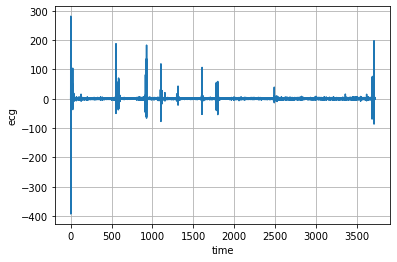

In [9]:
ecg.plot()

In [10]:
ibi = ph.BeatFromECG()(ecg)

In [11]:
ibi.get_duration() #seconds 

3720.0

In [12]:
# create label
label = np.zeros(3720)
label[0:600] = 1
label[600:3720] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label') 
#sampling_freq here is not intended as real sampfeq, only the distance between one point and the other (e.g. 10 = 10 units between 'begin' & 'end')

In [13]:
# IIR filtering : remove high frequency noise
ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [14]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [15]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

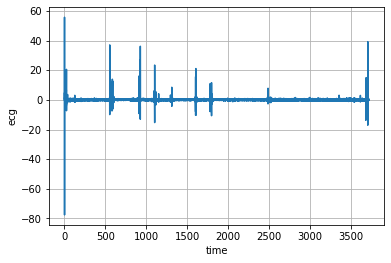

In [16]:
ecg.plot()

In [17]:
ibi = ph.BeatFromECG()(ecg)

In [18]:
ibi.get_duration()


3720.0

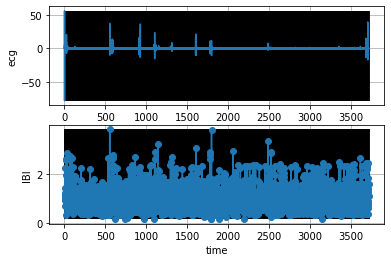

In [19]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [20]:
### physiological indicators 

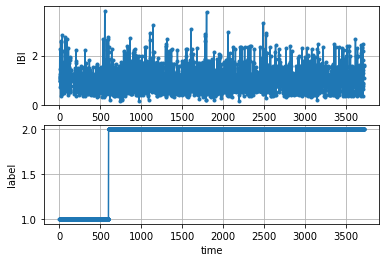

In [21]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()

In [22]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [23]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [25]:
# create a pandas dataframe
hrv_indicators_pp1 = pd.DataFrame(indicators, columns=col_names)
hrv_indicators_pp1.head()

,begin,end,label,RRmean,RRstd,rmsSD
0,0.0,60.0,1.0,1.098004,0.573100,0.731680
1,60.0,120.0,1.0,1.169716,0.491037,0.724136
2,120.0,180.0,1.0,1.107711,0.265607,0.417730
3,180.0,240.0,1.0,1.046223,0.340373,0.499943
4,240.0,300.0,1.0,0.903320,0.300921,0.438646


In [25]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c1a3adb50>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1a388550>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1a3adb10>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1a3bed10>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1a3b9e10>,
 'means': []}

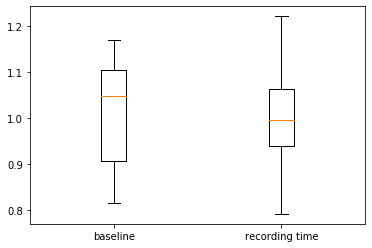

In [26]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['baseline', 'recording time'])

In [27]:
#frequency domain HRV indicators
HRV_FD = ph.preset_hrv_fd()
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


In [23]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

In [24]:
import pandas as pd

# create a pandas dataframe
FD_HRV_pp1_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_pp1_df

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,1.228516,61.228516,1.0,418.808284,957.419867,1025.554374,3080.687157
1,61.228516,121.228516,1.0,207.864712,694.581742,814.149004,2392.258618
2,121.228516,181.228516,1.0,140.516367,370.653176,809.100268,1996.750100
3,181.228516,241.228516,1.0,140.274964,448.755593,885.196647,2189.162781
4,241.228516,301.228516,1.0,117.079110,312.173256,680.322424,1907.873698
5,301.228516,361.228516,1.0,175.877472,458.098372,828.317041,2324.176320
6,361.228516,421.228516,1.0,126.831376,375.267657,691.750909,2033.864558
7,421.228516,481.228516,1.0,174.259385,428.707907,868.863983,2274.901547
8,481.228516,541.228516,1.0,183.507625,618.625762,783.264052,2351.611104
9,601.228516,661.228516,2.0,184.069063,425.317603,566.541117,1815.462872


In [27]:
#save data 
FD_HRV_pp1_df.to_csv('FD_HRV_pp1.csv')